In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from numpy import ndarray

from typing import Callable, List

# 01. Foundations
The aim of this chapter is to explain some foundational mental models that are essential for understanding how neural networks work. Specifically, we’ll cover nested mathematical functions and their derivatives. We’ll work our way up from the simplest possible building blocks to show that we can build complicated functions made up of a “chain” of constituent functions and, even when one of these functions is a matrix multiplication that takes in multiple inputs, compute the derivative of the functions’ outputs with respect to their inputs. Understanding how this process works will be essential to understanding neural networks, which we technically won’t begin to cover until `Chapter 2`.

## 1.1 Functions

In [2]:
# 平方函数
def square(x: ndarray) -> ndarray:
    return np.power(x, 2)

# Leaky ReLU函数
def leaky_relu(x: ndarray) -> ndarray:
    return np.maximum(0.2 * x, x)

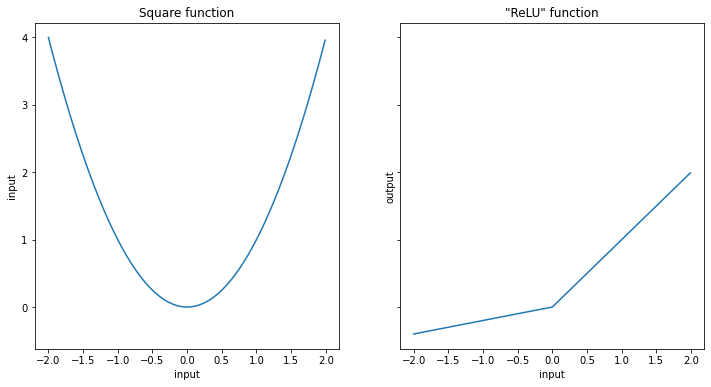

In [3]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(12, 6))  # 2 Rows, 1 Col

input_range = np.arange(-2, 2, 0.01)
ax[0].plot(input_range, square(input_range))
ax[0].set_title('Square function')
ax[0].set_xlabel('input')
ax[0].set_ylabel('input')

ax[1].plot(input_range, leaky_relu(input_range))
ax[1].set_title('"ReLU" function')
ax[1].set_xlabel('input')
ax[1].set_ylabel('output');

## 1.2 Derivatives
Derivatives, like functions, are an extremely important concept for understanding deep learning that many of you are probably familiar with. Also like functions, they can be depicted in multiple ways. We’ll start by simply saying at a high level that the derivative of a function at a point is the “rate of change” of the output of the function with respect to its input at that point. Let’s now walk through the same three perspectives on derivatives that we covered for functions to gain a better mental model for how derivatives work.

In [4]:
# 导数函数
def deriv(func: Callable[[ndarray], ndarray], input_: ndarray, diff: float = 0.001) -> ndarray:
    return (func(input_+diff)-func(input_-diff)) / (2*diff)

## 1.3 Nested Functions
Now we’ll cover a concept that will turn out to be fundamental to understanding neural networks: functions can be “nested” to form “composite” functions. What exactly do I mean by “nested”? I mean that if we have two functions that by mathematical convention we call $f_1$ and $f_2$, the output of one of the functions becomes the input to the next one, so that we can “string them together.”

In [5]:
# A Function takes in an ndarray as an argument and produces an ndarray
Array_Function = Callable[[ndarray], ndarray]

# A Chain is a list of functions
Chain = List[Array_Function]

In [6]:
# Evaluates two functions in a row, in a "Chain".
def chain_length_2(chain: Chain, x: ndarray) -> ndarray:
    assert len(chain) == 2, "Length of input 'chain' should be 2"
    f1 = chain[0]
    f2 = chain[1]
    return f2(f1(x))

## 1.4 The Chain Rule
The chain rule is a mathematical theorem that lets us compute derivatives of composite functions. Deep learning models are, mathematically, composite functions, and reasoning about their derivatives is essential to training them, as we’ll see in the next couple of chapters.

In [7]:
def sigmoid(x: ndarray) -> ndarray:
    return 1 / (1 + np.exp(-x))

In [8]:
# Uses the chain rule to compute the derivative of two nested functions: (f2(f1(x))' = f2'(f1(x)) * f1'(x)
def chain_deriv_2(chain: Chain, input_range: ndarray) -> ndarray:
    assert len(chain) == 2, "This function requires 'Chain' objects of length 2"
    assert input_range.ndim == 1, "Function requires a 1 dimensional ndarray as input_range"

    f1 = chain[0]
    f2 = chain[1]

    # df1/dx
    f1_of_x = f1(input_range)
    # df1/du
    df1dx = deriv(f1, input_range)
    # df2/du(f1(x))
    df2du = deriv(f2, f1(input_range))
    # Multiplying these quantities together at each point
    return df1dx * df2du

In [9]:
# Plots a chain function - a function made up of  multiple `consecutive ndarray` -> `ndarray` mappings, 
# across the input_range
# ax: matplotlib Subplot for plotting
def plot_chain(ax, chain: Chain, input_range: ndarray) -> None:
    assert input_range.ndim == 1, "Function requires a 1 dimensional ndarray as input_range"
    output_range = chain_length_2(chain, input_range)
    ax.plot(input_range, output_range)

# Uses the chain rule to plot the derivative of a function consisting of two nested functions.
# ax: matplotlib Subplot for plotting
def plot_chain_deriv(ax, chain: Chain, input_range: ndarray) -> ndarray:
    output_range = chain_deriv_2(chain, input_range)
    ax.plot(input_range, output_range)

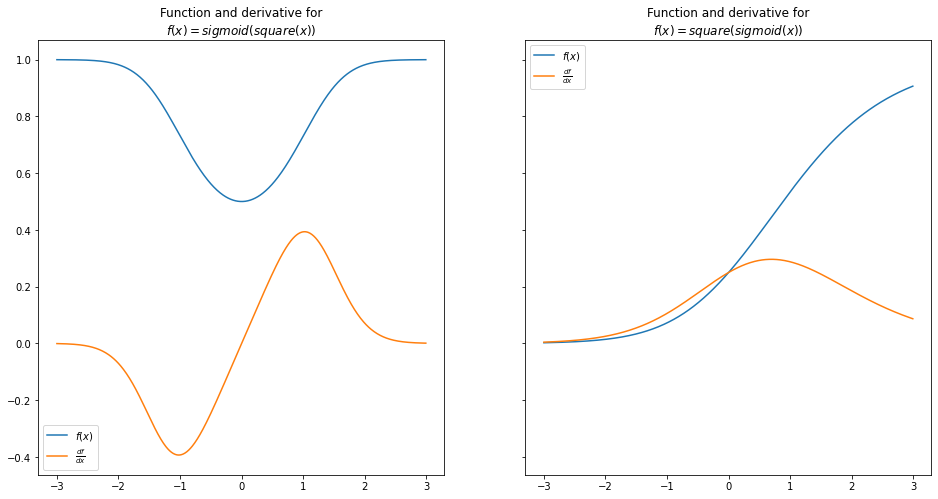

In [10]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(16, 8))  # 2 Rows, 1 Col

chain_1 = [square, sigmoid]
chain_2 = [sigmoid, square]

PLOT_RANGE = np.arange(-3, 3, 0.01)
plot_chain(ax[0], chain_1, PLOT_RANGE)
plot_chain_deriv(ax[0], chain_1, PLOT_RANGE)

ax[0].legend(["$f(x)$", "$\\frac{df}{dx}$"])
ax[0].set_title("Function and derivative for\n$f(x) = sigmoid(square(x))$")

plot_chain(ax[1], chain_2, PLOT_RANGE)
plot_chain_deriv(ax[1], chain_2, PLOT_RANGE)
ax[1].legend(["$f(x)$", "$\\frac{df}{dx}$"])
ax[1].set_title("Function and derivative for\n$f(x) = square(sigmoid(x))$");

## 1.5 A Slightly Longer Example
Let’s closely examine a slightly longer chain: if we have three mostly differentiable functions—$f_1, f_2, f_3$ —how would we go about computing the derivative of $f_1f_2f_3$? We “should” be able to do it, since from the calculus theorem mentioned previously, we know that the composite of any finite number of “mostly differentiable” functions is differentiable.

In [11]:
# Evaluates three functions in a row, in a "Chain".
def chain_length_3(chain: Chain, x: ndarray) -> ndarray:
    assert len(chain) == 3,  "Length of input 'chain' should be 3"
    f1 = chain[0]
    f2 = chain[1]
    f3 = chain[2]
    return f3(f2(f1(x)))

# Uses the chain rule to compute the derivative of three nested functions: 
# (f3(f2(f1)))' = f3'(f2(f1(x)))*f2'(f1(x))*f1'(x)
def chain_deriv_3(chain: Chain, input_range: ndarray) -> ndarray:
    assert len(chain) == 3, "This function requires 'Chain' objects to have length 3"
    
    f1 = chain[0]
    f2 = chain[1]
    f3 = chain[2]

    # f1(x)
    f1_of_x = f1(input_range)
    # f2(f1(x))
    f2_of_x = f2(f1_of_x)
    # df3du
    df3du = deriv(f3, f2_of_x)
    # df2du
    df2du = deriv(f2, f1_of_x)
    # df1dx
    df1dx = deriv(f1, input_range)
    # Multiplying these quantities together at each point
    return df1dx * df2du * df3du

In [12]:
# Plots a chain function - a function made up of multiple consecutive ndarray -> ndarray mappings, 
# across one range
# ax: matplotlib Subplot for plotting
def plot_chain(ax, chain: Chain, input_range: ndarray, length: int=2) -> None:
    assert input_range.ndim == 1, "Function requires a 1 dimensional ndarray as input_range"
    if length == 2:
        output_range = chain_length_2(chain, input_range)
    elif length == 3:
        output_range = chain_length_3(chain, input_range)
    ax.plot(input_range, output_range)

def plot_chain_deriv(ax, chain: Chain, input_range: ndarray, length: int=2) -> ndarray:
    '''
    Uses the chain rule to plot the derivative of two nested functions.
    ax: matplotlib Subplot for plotting
    '''
    if length == 2:
        output_range = chain_deriv_2(chain, input_range)
    elif length == 3:
        output_range = chain_deriv_3(chain, input_range)
    ax.plot(input_range, output_range)

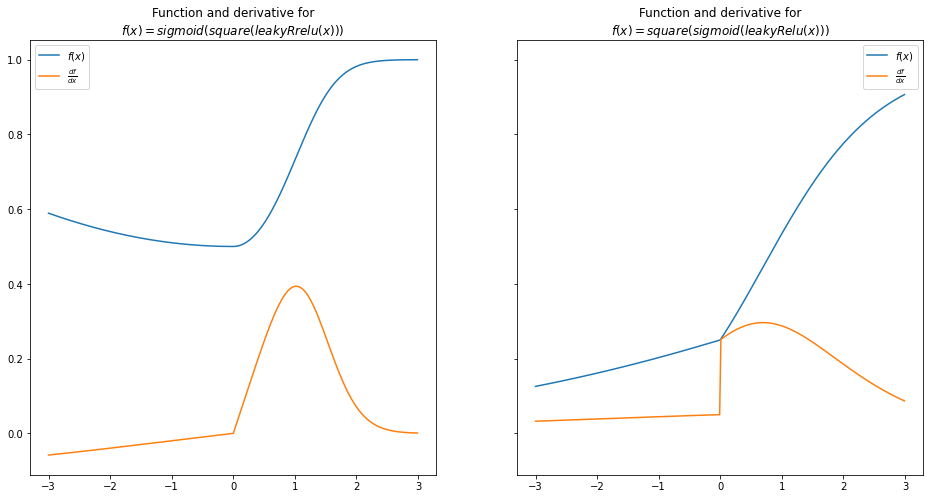

In [13]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(16, 8))  # 2 Rows, 1 Col

chain_1 = [leaky_relu, square, sigmoid]
chain_2 = [leaky_relu, sigmoid, square]

PLOT_RANGE = np.arange(-3, 3, 0.01)
plot_chain(ax[0], chain_1, PLOT_RANGE, length=3)
plot_chain_deriv(ax[0], chain_1, PLOT_RANGE, length=3)

ax[0].legend(["$f(x)$", "$\\frac{df}{dx}$"])
ax[0].set_title("Function and derivative for\n$f(x) = sigmoid(square(leakyRrelu(x)))$")

plot_chain(ax[1], chain_2, PLOT_RANGE, length=3)
plot_chain_deriv(ax[1], chain_2, PLOT_RANGE, length=3)
ax[1].legend(["$f(x)$", "$\\frac{df}{dx}$"])
ax[1].set_title("Function and derivative for\n$f(x) = square(sigmoid(leakyRelu(x)))$");

## 1.6 Functions with Multiple Inputs
By this point, we have a conceptual understanding of how functions can be strung together to form composite functions. We also have a sense of how to represent these functions as series of boxes that inputs go into and outputs come out of. Finally, we’ve walked through how to compute the derivatives of these functions so that we understand these derivatives both mathematically and as quantities computed via a step-by-step process with a “forward” and “backward” component.

Oftentimes, the functions we deal with in deep learning don’t have just one input. Instead, they have several inputs that at certain steps are added together, multiplied, or otherwise combined. As we’ll see, computing the derivatives of the outputs of these functions with respect to their inputs is still no problem: let’s consider a very simple scenario with multiple inputs, where two inputs are added together and then fed through another function.

In [14]:
# Function with multiple inputs and addition, forward pass
def multiple_inputs_add(x: ndarray, y: ndarray, sigma: Array_Function) -> float:
    assert x.shape == y.shape
    a = x + y
    return sigma(a)

## 1.7 Derivatives of Functions with Multiple Inputs
It shouldn’t seem surprising that we can compute the derivative of the output of such a function with respect to both of its inputs.

In [15]:
# Computes the derivative of this simple function with respect to both inputs
def multiple_inputs_add_backward(x: ndarray, y: ndarray, sigma: Array_Function) -> float:
    # Compute "forward pass"
    a = x + y
    # Compute derivatives
    dsda = deriv(sigma, a)
    dadx, dady = 1, 1
    return dsda * dadx, dsda * dady

## 1.8 Functions with Multiple Vector Inputs
In deep learning, we deal with functions whose inputs are vectors or matrices. Not only can these objects be added, multiplied, and so on, but they can also combined via a dot product or a matrix multiplication. In the rest of this chapter, I’ll show how the mathematics of the chain rule and the logic of computing the derivatives of these functions using a forward and backward pass can still apply.

These techniques will end up being central to understanding why deep learning works. In deep learning, our goal will be to fit a model to some data. More precisely, this means that we want to find a mathematical function that maps observations from the data—which will be inputs to the function—to some desired predictions from the data—which will be the outputs of the function—in as optimal a way as possible. It turns out these observations will be encoded in matrices, typically with row as an observation and each column as a numeric feature for that observation. We’ll cover this in more detail in the next chapter; for now, being able to reason about the derivatives of complex functions involving dot products and matrix multiplications will be essential.

Let’s start by defining precisely what I mean, mathematically.

### Math
A typical way to represent a single data point, or "observation", in a neural network is as a row with $n$ features, where each feature is simply a number $x_1$, $x_2$, and so on, up to $x_n$:

$$X = [x_1, x_2, ... x_n]$$

A canonical example to keep in mind here is predicting housing prices, which we’ll build a neural network from scratch to do in the next chapter; in this example, $x_1$, $x_2$, and so on are numerical features of a house, such as its square footage or its proximity to schools.

## 1.9 Creating New Features from Existing Features
Perhaps the single most common operation in neural networks is to form a “weighted sum” of these features, where the weighted sum could emphasize certain features and de-emphasize others and thus be thought of as a new feature that itself is just a combination of old features. A concise way to express this mathematically is as a dot product of this observation, with some set of “weights” of the same length as the features, $w_1$, $w_2$, and so on, up to $w_n$. 

$$W = \begin{bmatrix} w_1 \\ w_2 \\ \vdots \\ w_n \end{bmatrix}$$

then we could define the output of this operation as:

$$N = \mathit{v}(X,W) = X \times W = x_1\times w_1 + x_2\times w_2 + \cdots + x_n\times w_n$$

In [16]:
# Computes the forward pass of a matrix multiplication
def matmul_forward(X: ndarray, W: ndarray) -> ndarray:
    assert X.shape[1] == W.shape[0], \
    '''
    For matrix multiplication, the number of columns in the first array should match the
    number of rows in the second, instead the number of columns in the first array is {0}
    and the number of rows in the second array is {1}
    '''.format(X.shape[1], W.shape[0])

    # matrix multiplication
    N = np.dot(X, W)
    return N

## 1.10 Derivatives of Functions with Multiple Vector Inputs
For functions that simply take one input as a number and produce one output, like $f(x) = x^2$ or $f(x) = \text{sigmoid}(x)$, computing the derivative is straightforward: we simply apply rules from calculus. For vector functions, it isn’t immediately obvious what the derivative is: if we write a dot product as $\mathit{v}(X,W)=N$, as in the prior section, the question naturally arises—what would $\frac{\partial N}{\partial X}$ and $\frac{\partial N}{\partial W}$ be?

### Math
First, how would we even define “the derivative with respect to a matrix”? Recalling that the matrix syntax is just shorthand for a bunch of numbers arranged in a particular form, “the derivative with respect to a matrix” really means “the derivative with respect to each element of the matrix”. Since $X$ is a row, a natural way to define it is:

$$\frac{\partial \mathit{v}}{\partial X} = \bigg[\frac{\partial \mathit{v}}{\partial x_1}, \frac{\partial \mathit{v}}{\partial x_2}, \cdots, \frac{\partial \mathit{v}}{\partial x_n}\bigg]$$

When $\mathit{v}(X,W) = X \times W = x_1\times w_1 + x_2\times w_2 + x_3\times w_3$, then
$$\frac{\partial \mathit{v}}{\partial x_1}= w_1, \frac{\partial \mathit{v}}{\partial x_2}=w_2, \frac{\partial \mathit{v}}{\partial x_3}=w_3$$

And so, 

$$\frac{\partial \mathit{v}}{\partial X} = [w_1 \quad w_2 \quad w_3]=W^{\top}$$

$$\frac{\partial \mathit{v}}{\partial W} = \begin{bmatrix} x_1 \\ x_2 \\ w_3 \end{bmatrix}=X^{\top}$$

In [17]:
# Computes the backward pass of a matrix multiplication with respect to the first argument.
def matmul_backward_first(X: ndarray, W: ndarray) -> ndarray:
    # backward pass
    dNdX = np.transpose(W, (1, 0))
    return dNdX

In [18]:
np.random.seed(190203)

X = np.random.randn(1,3)
W = np.random.randn(3,1)

X, W, matmul_backward_first(X, W)

(array([[ 0.47231121,  0.61514271, -1.72622715]]),
 array([[ 0.92819676],
        [-0.60754888],
        [-1.22136052]]),
 array([[ 0.92819676, -0.60754888, -1.22136052]]))

## 1.11 Vector Functions and Their Derivatives: One Step Further
Deep learning models, of course, involve more than one operation: they include long chains of operations, some of which are vector functions like the one covered in the last section, and some of which simply apply a function elementwise to the ndarray they receive as input. Therefore, we’ll now look at computing the derivative of a composite function that includes both kinds of functions. Let’s suppose our function takes in the vectors $X$ and $W$, performs the dot product described in the prior section which we’ll denote as $\mathit{v} = (X,v)$ — and then feeds the vectors through a function $\sigma$. We’ll express the same objective as before, but in new language: we want to compute the gradients of the output of this new function with respect to $X$ and $W$. Again, starting in the next chapter, we’ll see in precise detail how this is connected to what neural networks do, but for now we just want to build up the idea that we can compute gradients for computational graphs of arbitrary complexity.

### Math
Mathematically, this is straightforward as well:

$$s = f(X,W) = \sigma(\mathit{v}(X,W)) = \sigma(x_1\times w_1 + x_2\times w_2 + x_3\times w_3)$$

In [19]:
# Computes the forward pass of a function involving matrix multiplication, one extra function
def matrix_forward_extra(X: ndarray, W: ndarray, sigma: Array_Function) -> ndarray:
    assert X.shape[1] == W.shape[0]
    # matrix multiplication
    N = np.dot(X, W)
    # feeding the output of the matrix multiplication through sigma
    S = sigma(N)
    return S

### Vector Functions and Their Derivatives: The Backward Pass
The backward pass is similarly just a straightforward extension of the prior example.

$$\frac{\partial f}{\partial X} = \frac{\partial\sigma}{\partial u}(\mathit{v}(X,W))\times \frac{\partial \mathit{v}}{\partial X}(X,W)$$

But the first part of this is simply:

$$\frac{\partial\sigma}{\partial u}(\mathit{v}(X,W)) = \frac{\partial\sigma}{\partial u}(x_1\times w_1 + x_2\times w_2 + x_3\times w_3)$$

the second part of this is:

$$\frac{\partial \mathit{v}}{\partial X}(X,W) = W^{\top}$$

and then:

$$\frac{\partial f}{\partial X} = \frac{\partial\sigma}{\partial u}(\mathit{v}(X,W))\times \frac{\partial \mathit{v}}{\partial X}(X,W) = \frac{\partial\sigma}{\partial u}(x_1\times w_1 + x_2\times w_2 + x_3\times w_3)\times W^{\top}$$

which, as in the preceding example, results in a vector of the same shape as $X$, since the final answer is a number, $\displaystyle\frac{\partial\sigma}{\partial u}(x_1\times w_1 + x_2\times w_2 + x_3\times w_3)$, times a vector of the same shape as $X$ in $W^{\top}$.

In [20]:
# Computes the derivative of our matrix function with respect to the first element.
def matrix_function_backward_1(X: ndarray, W: ndarray, sigma: Array_Function) -> ndarray:
    assert X.shape[1] == W.shape[0]
    print("X shape: {}, W shape {}".format(X.shape, W.shape))
    # matrix multiplication
    N = np.dot(X, W)
    print("N = X*W, N shape: {}".format(N.shape))
    # feeding the output of the matrix multiplication through sigma
    S = sigma(N)
    print("S = sigma(N), S shape: {}".format(S.shape))
    # backward calculation
    dSdN = deriv(sigma, N)
    print("dSdN shape: {}".format(dSdN.shape))
    # dNdX
    dNdX = np.transpose(W, (1, 0))
    print("dNdX shape: {}".format(dNdX.shape))
    # multiply them together; since dNdX is 1x1 here, order doesn't matter
    return np.dot(dSdN, dNdX)

In [21]:
print(matrix_function_backward_1(X, W, sigmoid))

X shape: (1, 3), W shape (3, 1)
N = X*W, N shape: (1, 1)
S = sigma(N), S shape: (1, 1)
dSdN shape: (1, 1)
dNdX shape: (1, 3)
[[ 0.08516695 -0.05574581 -0.11206627]]


## 1.12 Computational Graph with Two 2D Matrix Inputs
In deep learning, and in machine learning more generally, we deal with operations that take as input two 2D arrays, one of which represents a batch of data $X$ and the other of which represents the weights $W$. In the next chapter, we’ll dive deep into why this makes sense in a modeling context, but in this chapter we’ll just focus on the mechanics and the math behind this operation. Specifically we’ll walk through a simple example in detail and show that even when multiplications of 2D matrices are involved, rather than just dot products of 1D vectors, the reasoning we’ve been using throughout this chapter still makes mathematical sense and is in fact extremely easy to code.

As before, the math needed to derive these results gets not difficult, but messy. Nevertheless, the result is quite clean. And, of course, we’ll break it down step by step and always connect it back to both code and diagrams.

### Math
Let’s suppose that:

$$X = \begin{bmatrix} x_{11} & x_{12} & x_{13} \\ x_{21} & x_{22} & x_{23} \\ x_{31} & x_{32} & x_{33} \end{bmatrix}, W = \begin{bmatrix} w_{11} & w_{12} \\ w_{21} & w_{22} \\ w_{31} & w_{32} \end{bmatrix}$$

Now we’ll define the following straightforward operations to these matrices:
1. Multiply these matrices together. As before, we’ll denote the function that does this as $\mathit{v}(X,W)$ and the output as $N$, so that $N = \mathit{v}(X, W)$.
2. Feed $N$ result through some differentiable function $\sigma$, and define ($S = \sigma(N)$.

If you think about this for a bit, you may realize that something is different from the previous examples that we’ve looked at: $S$ is now a matrix, not simply a number. And what, after all, does the gradient of one matrix with respect to another matrix mean?

This leads us to a subtle but important idea: we may perform whatever series of operations on multidimensional arrays we want, but for the notion of a “gradient” with respect to some output to be well defined, we need to sum (or otherwise aggregate into a single number) the final array in the sequence so that the notion of “how much will changing each element of $X$ affect the output” will even make sense.

Let’s make this mathematically concrete. First, let’s multiply $X$ and $W$:

$$X \times W = \begin{bmatrix} x_{11}\times w_{11}+x_{12}\times w_{21}+x_{13}\times w_{31} & x_{11}\times w_{12}+x_{12}\times w_{22}+x_{13}\times w_{32} \\  x_{21}\times w_{11}+x_{22}\times w_{21}+x_{23}\times w_{31} & x_{21}\times w_{12}+x_{22}\times w_{22}+x_{23}\times w_{32} \\ x_{31}\times w_{11}+x_{32}\times w_{21}+x_{33}\times w_{31} & x_{31}\times w_{12}+x_{32}\times w_{22}+x_{33}\times w_{32} \end{bmatrix} = \begin{bmatrix} XW_{11} & XW_{12} \\ XW_{21} & XW_{22} \\ XW_{31} & XW_{32} \end{bmatrix}$$

where we denote row $i$ and column $j$ in the resulting matrix as $XW_{ij}$ for convenience.

Next, we’ll feed this result through $\sigma$, which just means applying $\sigma$ to every element of the matrix $X \times W$:

$$\sigma(X\times W) = \begin{bmatrix}\sigma(x_{11}\times w_{11}+x_{12}\times w_{21}+x_{13}\times w_{31}) & \sigma(x_{11}\times w_{12}+x_{12}\times w_{22}+x_{13}\times w_{32}) \\ \sigma(x_{21}\times w_{11}+x_{22}\times w_{21}+x_{23}\times w_{31}) & \sigma(x_{21}\times w_{12}+x_{22}\times w_{22}+x_{23}\times w_{32}) \\ \sigma(x_{31}\times w_{11}+x_{32}\times w_{21}+x_{33}\times w_{31}) & \sigma(x_{31}\times w_{12}+x_{32}\times w_{22}+x_{33}\times w_{32}) \end{bmatrix} = \begin{bmatrix}\sigma(XW_{11}) & \sigma(XW_{12}) \\ \sigma(XW_{21}) & \sigma(XW_{22}) \\ \sigma(XW_{31}) & \sigma(XW_{32}) \end{bmatrix}$$

Finally, we can simply sum up these elements:

$$L = \Lambda(\sigma(X\times W)) = \Lambda\Bigg(\begin{bmatrix}\sigma(XW_{11}) & \sigma(XW_{12}) \\ \sigma(XW_{21}) & \sigma(XW_{22}) \\ \sigma(XW_{31}) & \sigma(XW_{32}) \end{bmatrix}\Bigg) = \sigma(XW_{11})+\sigma(XW_{12})+\sigma(XW_{21})+\sigma(XW_{22})+\sigma(XW_{31})+\sigma(XW_{32})$$

Now we are back in a pure calculus setting: we have a number, $L$, and we want to figure out the gradient of $L$ with respect to $X$ and $W$; that is, we want to know how much changing each element of these input matrices ($x_{11}, w_{21}$, and so on) would change $L$. We can write this as:

$$\frac{\partial\Lambda}{\partial u}(X) = \displaystyle\begin{bmatrix}\frac{\partial\Lambda}{\partial u}(x_{11}) &\frac{\partial\Lambda}{\partial u}(x_{12}) & \frac{\partial\Lambda}{\partial u}(x_{13}) \\ \frac{\partial\Lambda}{\partial u}(x_{21}) &\frac{\partial\Lambda}{\partial u}(x_{22}) & \frac{\partial\Lambda}{\partial u}(x_{23}) \\ \frac{\partial\Lambda}{\partial u}(x_{31}) &\frac{\partial\Lambda}{\partial u}(x_{32}) & \frac{\partial\Lambda}{\partial u}(x_{33}) \end{bmatrix}$$

In [22]:
# Computing the result of the forward pass of this function with
# input ndarrays X and W and function sigma.
def matrix_function_forward_sum(X: ndarray, W: ndarray, sigma: Array_Function) -> float:
    assert X.shape[1] == W.shape[0]
    # matrix multiplication
    N = np.dot(X, W)
    # feeding the output of the matrix multiplication through sigma
    S = sigma(N)
    # sum all the elements
    L = np.sum(S)
    return L

## 1.13 The Fun Part: The Backward Pass
Now we want to “perform the backward pass” for this function, showing how, even when a matrix multiplication is involved, we can end up calculating the gradient of $N$ with respect to each of the elements of our input ndarrays. With this final step figured out, starting to train real machine learning models in `Chapter 2` will be straightforward. First, let’s remind ourselves what we are doing, conceptually.

### Math
Let’s first note that we could compute this directly. The value $L$ is indeed a function of $x_{11}, x_{12}$, and so on, all the way up to $x_{33}$.

We can write $L$ as $\Lambda\big(\sigma(\mathit{v}(X,W))\big)$. If this were a regular function, we would just write the chain rule:

$$\frac{\partial\Lambda}{\partial X}(X) = \frac{\partial\mathit{v}}{\partial X}(X,W)\times\frac{\partial\sigma}{\partial u}(N)\times\frac{\partial\Lambda}{\partial u}(S)$$

The first derivative is the most straightforward. We want to know how much $L$ (the output of $\Lambda$) will increase if each element of $S$ increases. Since $L$ is the sum of all the elements of $S$, this derivative is simply:

$$\frac{\partial\Lambda}{\partial u}(S) = \begin{bmatrix} 1 & 1 \\  1 & 1 \\  1 & 1 \end{bmatrix}$$

since increasing any element of $S$ by, say, $0.46$ units would increase $\Lambda$ by $0.46$ units.

Next, we have $\displaystyle\frac{\partial\sigma}{\partial u}(N)$. This is simply the derivative of whatever function $\sigma$ is, evaluated at the elements in $N$:

$$\begin{bmatrix}\displaystyle\frac{\partial\sigma}{\partial u}(XW_{11}) & \displaystyle\frac{\partial\sigma}{\partial u}(XW_{12}) \\ \displaystyle\frac{\partial\sigma}{\partial u}(XW_{21}) & \displaystyle\frac{\partial\sigma}{\partial u}(XW_{22}) \\ \displaystyle\frac{\partial\sigma}{\partial u}(XW_{31}) & \displaystyle\frac{\partial\sigma}{\partial u}(XW_{32}) \end{bmatrix}$$

Note that at this point we can say for certain that we can multiply these two derivatives together elementwise and compute $\frac{\partial L}{\partial u}(N)$:

$$\frac{\partial\Lambda}{\partial u}(N) = \frac{\partial\Lambda}{\partial u}(S)\times\frac{\partial\sigma}{\partial u}(N) = \begin{bmatrix}\displaystyle\frac{\partial\sigma}{\partial u}(XW_{11}) & \displaystyle\frac{\partial\sigma}{\partial u}(XW_{12}) \\ \displaystyle\frac{\partial\sigma}{\partial u}(XW_{21}) & \displaystyle\frac{\partial\sigma}{\partial u}(XW_{22}) \\ \displaystyle\frac{\partial\sigma}{\partial u}(XW_{31}) & \displaystyle\frac{\partial\sigma}{\partial u}(XW_{32}) \end{bmatrix} \times \begin{bmatrix} 1 & 1 \\  1 & 1 \\  1 & 1 \end{bmatrix} = \begin{bmatrix}\displaystyle\frac{\partial\sigma}{\partial u}(XW_{11}) & \displaystyle\frac{\partial\sigma}{\partial u}(XW_{12}) \\ \displaystyle\frac{\partial\sigma}{\partial u}(XW_{21}) & \displaystyle\frac{\partial\sigma}{\partial u}(XW_{22}) \\ \displaystyle\frac{\partial\sigma}{\partial u}(XW_{31}) & \displaystyle\frac{\partial\sigma}{\partial u}(XW_{32}) \end{bmatrix}$$

The next thing we want, based on the diagram and applying the chain rule, is $\displaystyle\frac{\partial\mathit{v}}{\partial u}(X)$. Recall, however, that $N$, the output of $\mathit{v}$, was just the result of a matrix multiplication of $X$ with $W$. Thus we want some notion of how much increasing each element of $X$ (a $3 \times 3$ matrix) will increase each element of $N$ (a $3 \times 2$ matrix).

We were in the fortunate situation of $X$ and $W$ being transposes of each other in terms of shape. That being the case, we could show that $\displaystyle\frac{\partial\mathit{v}}{\partial u}(X) = W^{\top}$ and $\displaystyle\frac{\partial\mathit{v}}{\partial u}(W) = X^{\top}$:

$$\frac{\partial\Lambda}{\partial u}(X) = \frac{\partial\Lambda}{\partial u}(S)\times\frac{\partial\sigma}{\partial u}(N)\times W^{\top}$$

> This means that even if the operations in our computational graph involve multiplying matrices with multiple rows and columns, and even if the shapes of the outputs of those operations are different than those of the inputs, we can still include these operations in our computational graph and backpropagate through them using “chain rule” logic. This is a critical result, without which training deep learning models would be much more cumbersome, as you’ll appreciate further after the next chapter.

In [23]:
# Compute derivative of matrix function with a sum with respect to the first matrix input
def matrix_function_backward_sum_1(X: ndarray, W: ndarray, sigma: Array_Function) -> ndarray:
    assert X.shape[1] == W.shape[0]
    # matrix multiplication
    N = np.dot(X, W)
    # feeding the output of the matrix multiplication through sigma
    S = sigma(N)
    # sum all the elements
    L = np.sum(S)
    # dLdS - just 1s
    dLdS = np.ones_like(S)
    # dSdN
    dSdN = deriv(sigma, N)
    # dLdN
    dLdN = dLdS * dSdN
    # dNdX
    dNdX = np.transpose(W, (1, 0))
    # dLdX
    dLdX = np.dot(dSdN, dNdX)
    return dLdX

Now let’s verify that everything worked:

In [24]:
np.random.seed(190204)
X = np.random.randn(3, 3)
W = np.random.randn(3, 2)

print("X:")
print(X)

print("L:")
print(round(matrix_function_forward_sum(X, W, sigmoid), 4))
print()
print("dLdX:")
print(matrix_function_backward_sum_1(X, W , sigmoid))

X:
[[-1.57752816 -0.6664228   0.63910406]
 [-0.56152218  0.73729959 -1.42307821]
 [-1.44348429 -0.39128029  0.1539322 ]]
L:
2.3755

dLdX:
[[ 0.2488887  -0.37478057  0.01121962]
 [ 0.12604152 -0.27807404 -0.13945837]
 [ 0.22992798 -0.36623443 -0.02252592]]


As in the previous example, since `dLdX` represents the gradient of $X$ with respect to $L$, this means that the top-left element indicates that $\displaystyle\frac{\partial\Lambda}{\partial x_{11}}(X,W)=0.2489$.

Thus, if the matrix math for this example was correct, then increasing $x_{11}$ by 0.001 should increase $L$ by $0.001 \times 0.2489$. Indeed, we see that this is what happens:

In [25]:
X1 = X.copy()
X1[0, 0] += 0.001

print(round((matrix_function_forward_sum(X1,W,sigmoid) - matrix_function_forward_sum(X,W,sigmoid))/0.001, 4))

0.2489
